示例为利用pytorch中的RNN进行正弦函数和余弦函数的回归预测

In [2]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
torch.__version__

'1.0.1.post2'

In [3]:
# 定义超参数
TIME_STEP = 10       # RNN时间步长，每个序列（周期）取10个点
INPUT_SIZE = 1       # RNN输入特征大小，因为是点序列，所以为1
HIDDEN_SIZE = 64     # RNN隐藏层单元数量
EPOCH = 300          # 300个周期
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
h_state = None    # 初始隐藏层状态 

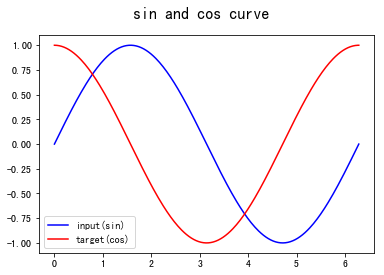

In [4]:
# 作图示意
steps = np.linspace(0, 2*np.pi, 250, dtype=np.float32)
x_np = np.sin(steps)
y_np = np.cos(steps)

plt.figure(1)
plt.suptitle("sin and cos curve", fontsize=16)
plt.plot(steps, x_np, "b-", label='input(sin)')
plt.plot(steps, y_np, "r-", label='target(cos)')
plt.legend(loc='best')
plt.show()

In [7]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = torch.nn.RNN(num_layers=1, 
                                input_size=INPUT_SIZE, 
                                hidden_size=HIDDEN_SIZE, 
                                batch_first=True)
        self.out = torch.nn.Linear(HIDDEN_SIZE, 1)
    def forward(self, x, h_state):    # 需传递隐藏层信息
        # x shape: (batch, time_stpes, input_size)
        # h_state shape: (num_layers, batch, hidden_size)
        # r_out shape: (batch, time_steps, hidden_size)
        r_out, h_state = self.rnn(x, h_state)
        
        outs = []     # 保存所有的输出
        for step in range(r_out.size(1)):   # 即timestep方向
            outs.append(self.out(r_out[:, step, :]))
        return torch.stack(outs, dim=1), h_state
    
        # 另一种简遍写法  
        # r_out = r_out.view(-1, HIDDEN_SIZE)   # 把bacth*time_step合并到第一个维度
        # outs = self.out(r_out)
        # outs = outs.view(-1,TIME_STEP,1)
        # return outs, h_state

net = Net().to(DEVICE)
print(net)

Net(
  (rnn): RNN(1, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
)


In [8]:
# 定义损失函数和优化器
criteria = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())

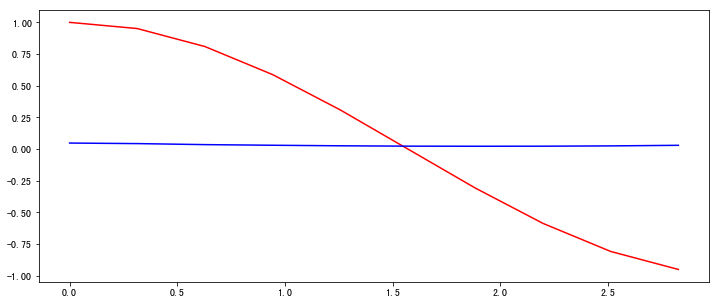

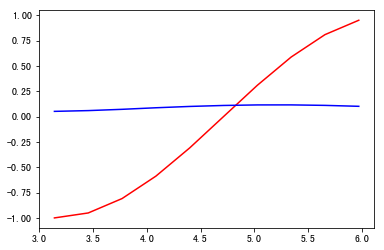

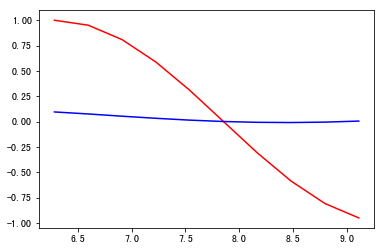

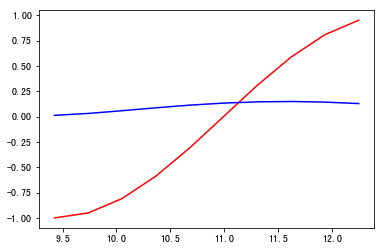

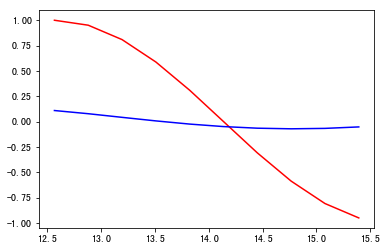

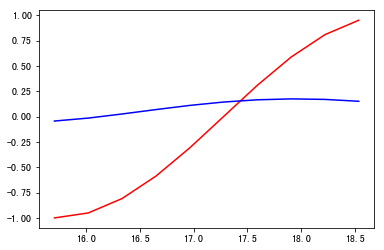

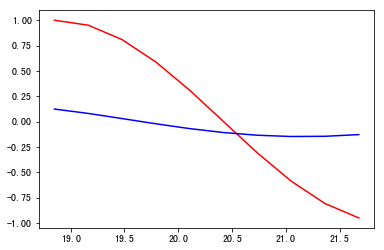

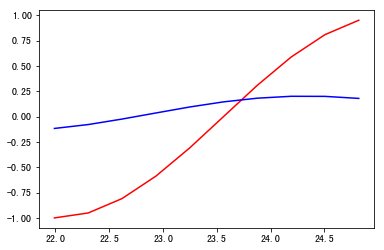

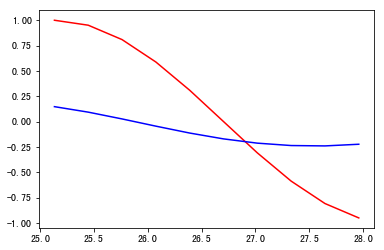

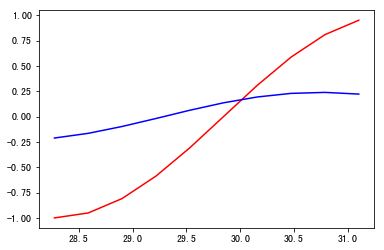

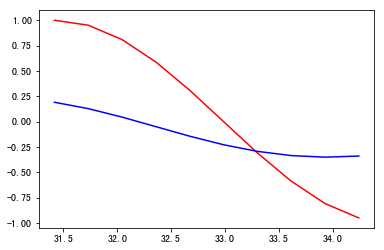

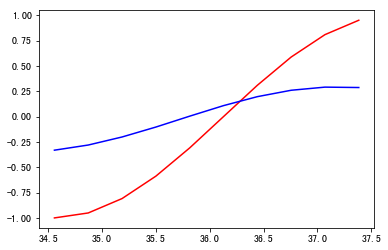

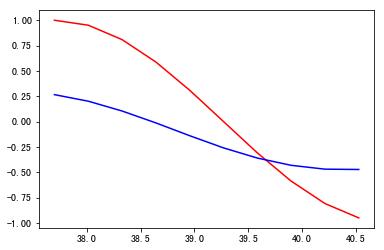

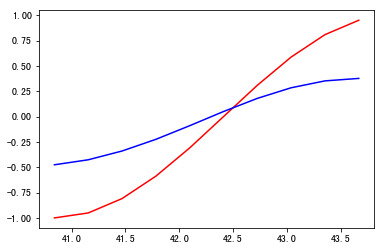

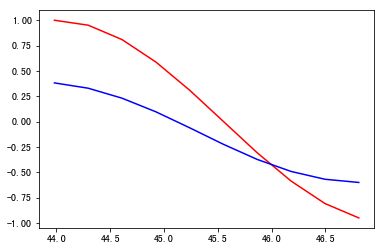

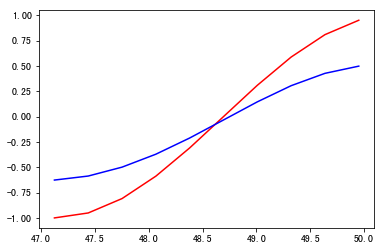

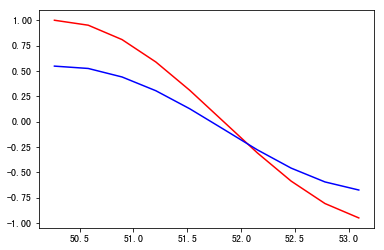

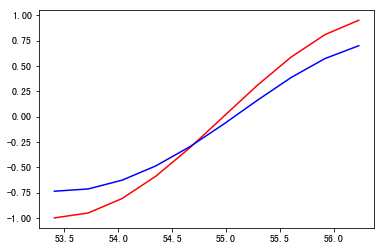

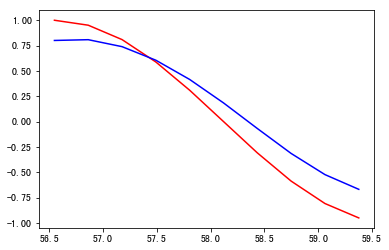

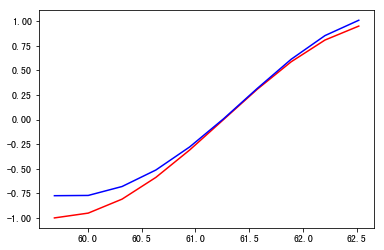

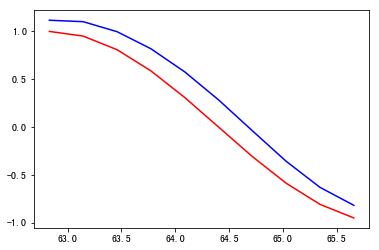

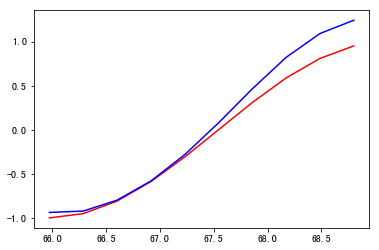

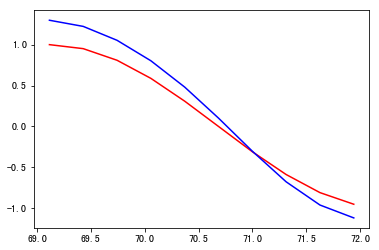

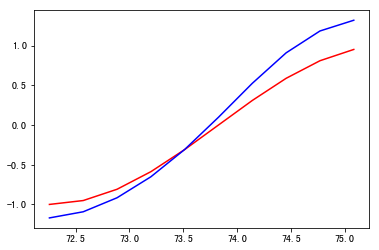

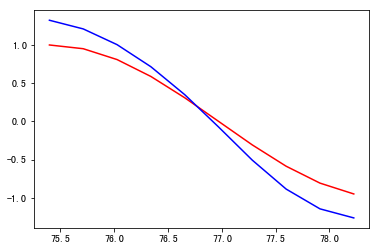

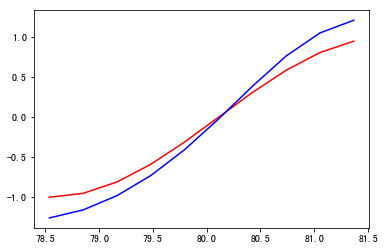

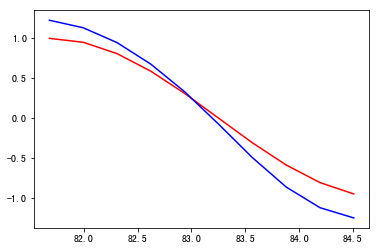

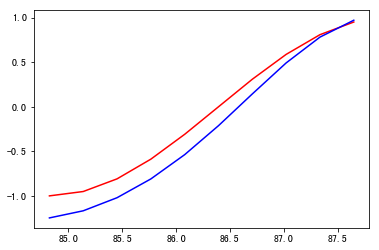

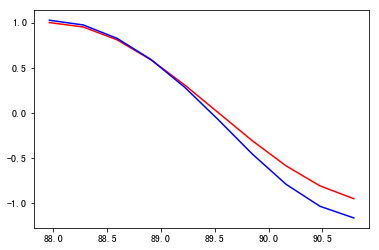

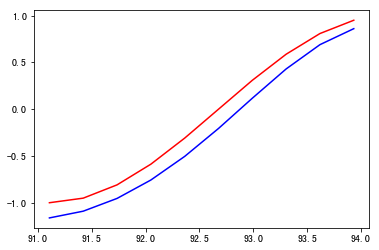

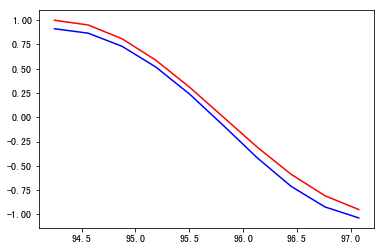

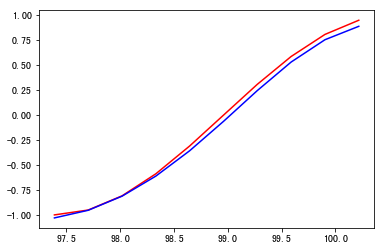

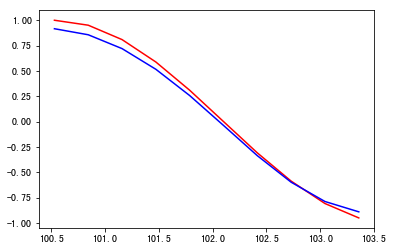

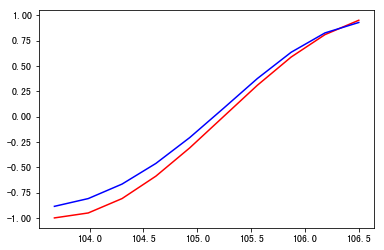

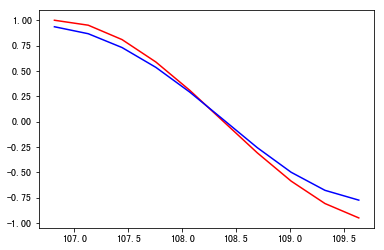

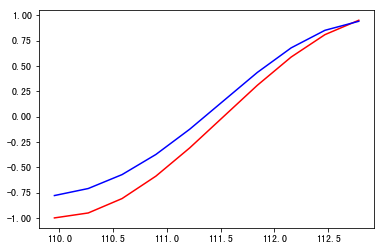

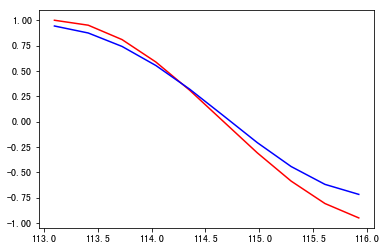

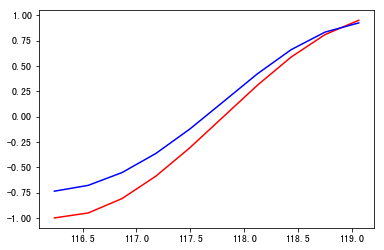

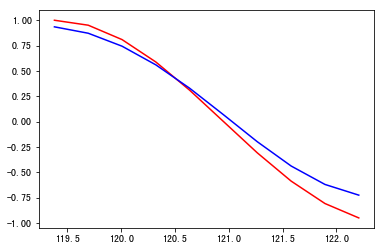

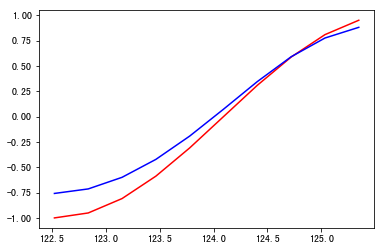

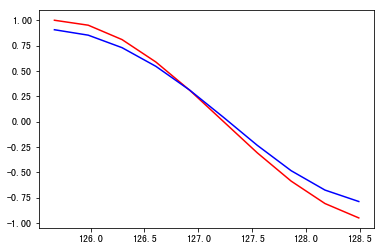

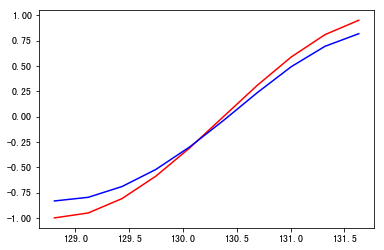

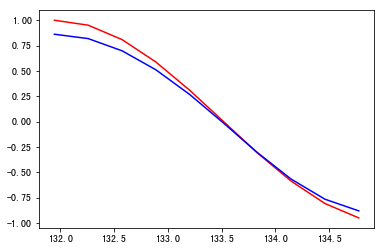

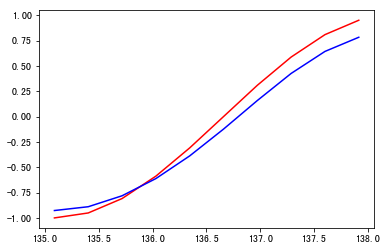

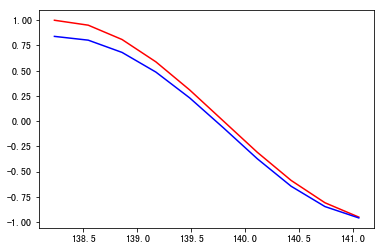

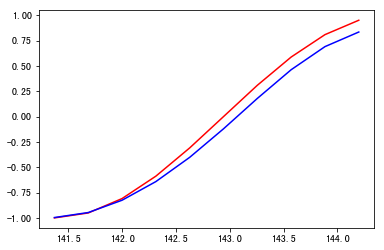

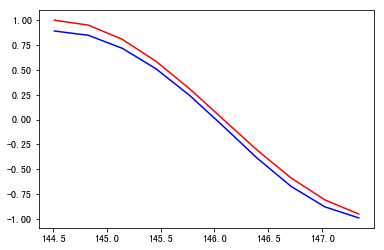

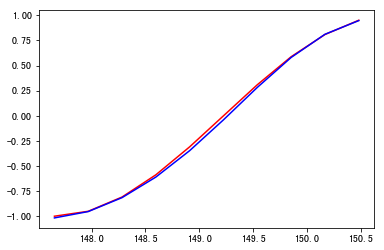

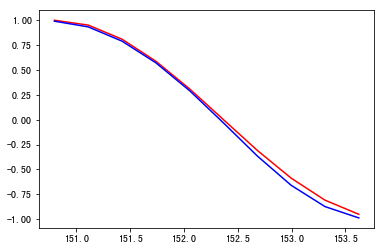

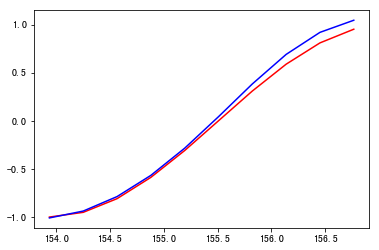

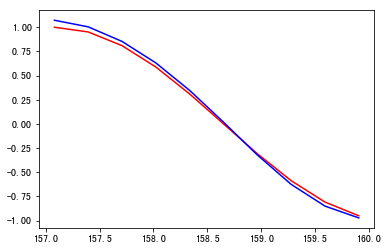

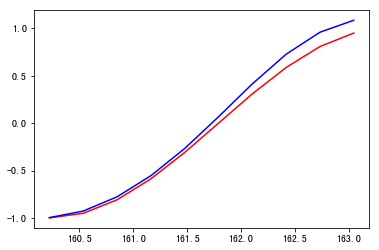

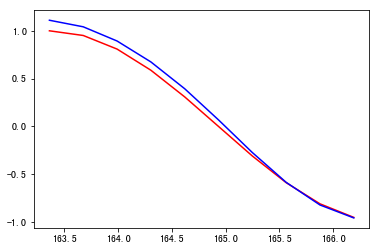

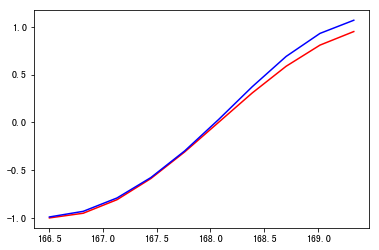

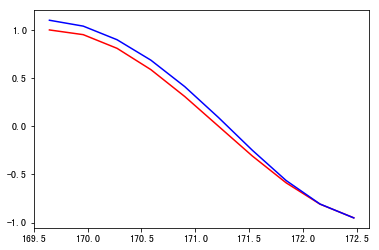

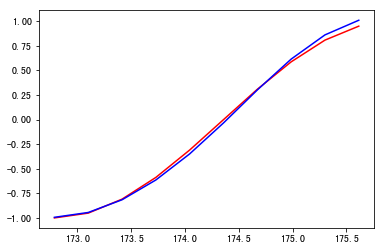

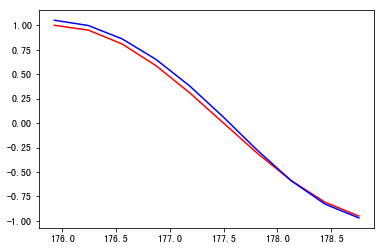

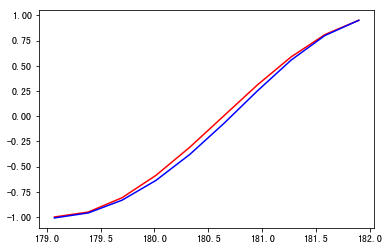

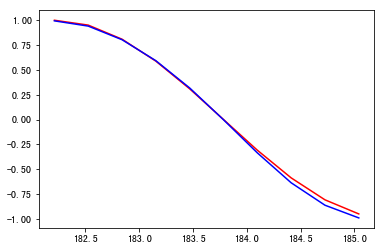

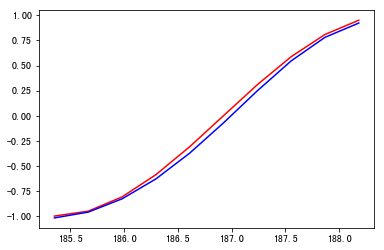

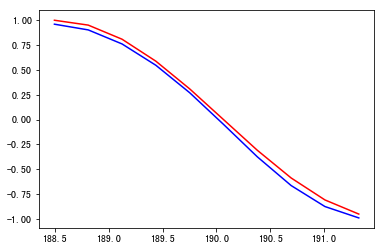

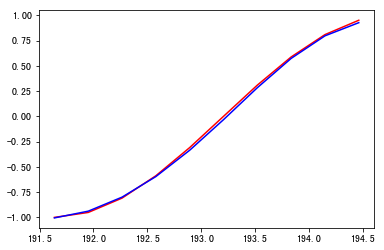

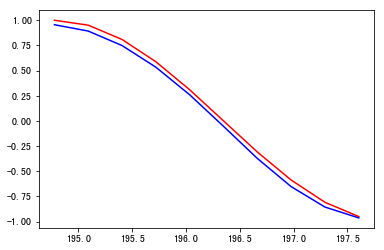

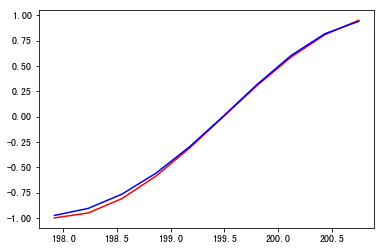

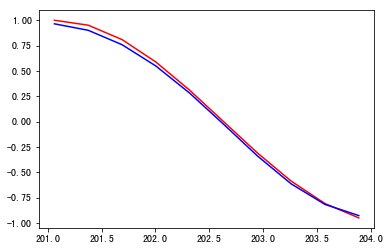

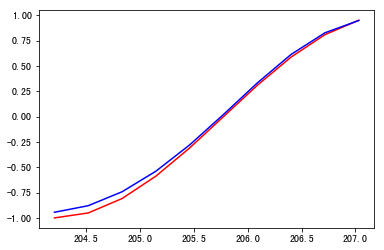

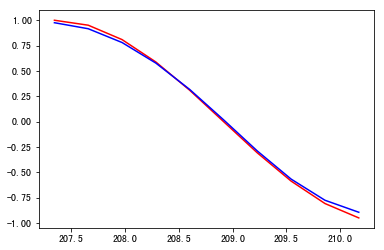

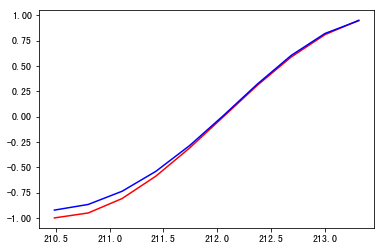

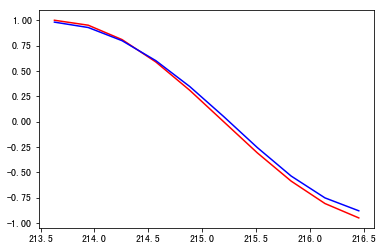

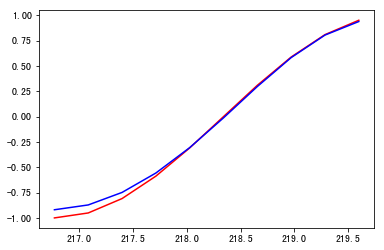

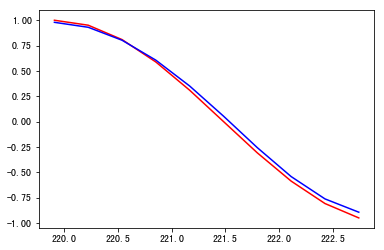

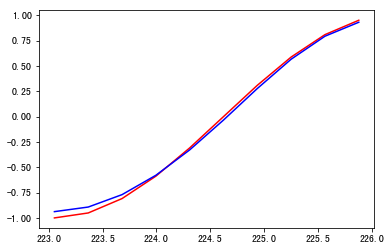

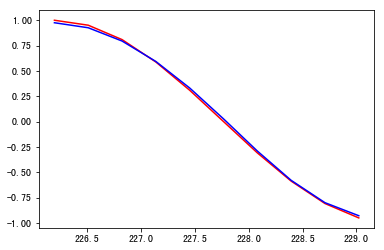

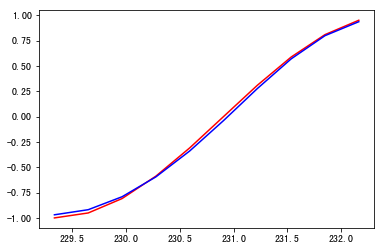

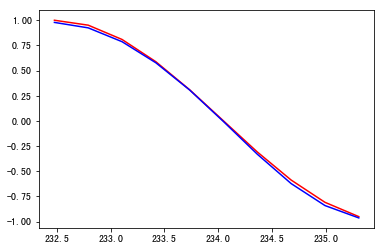

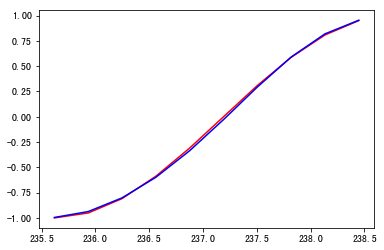

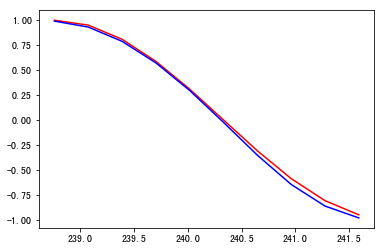

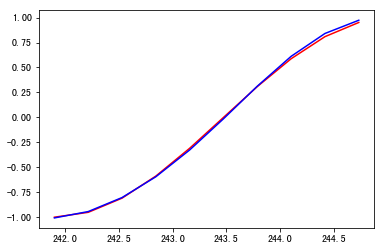

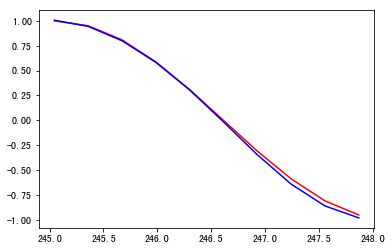

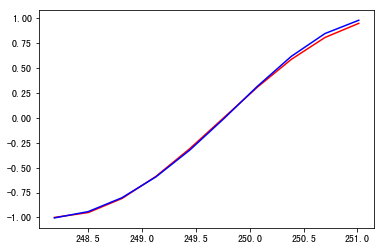

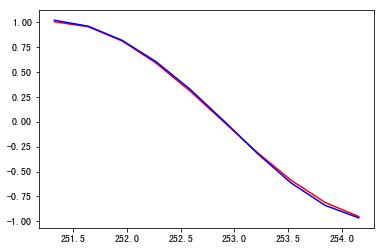

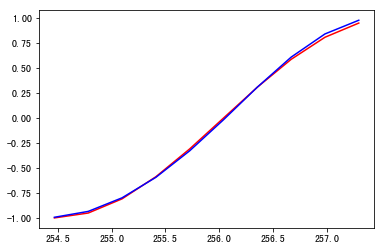

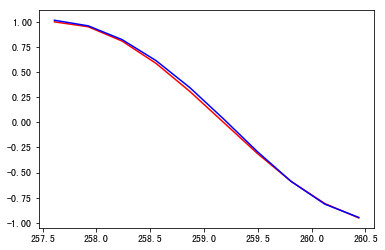

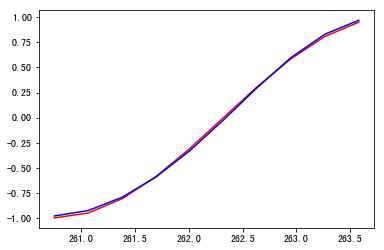

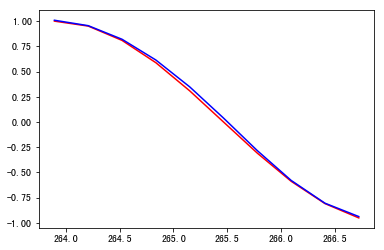

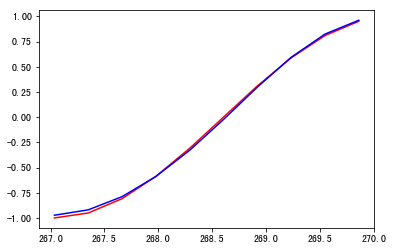

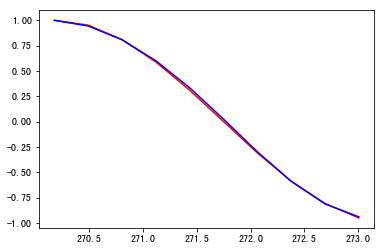

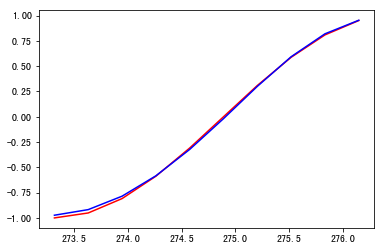

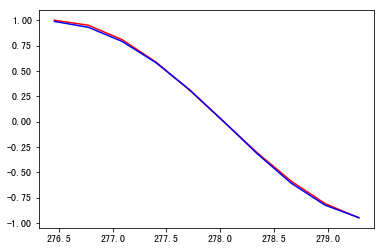

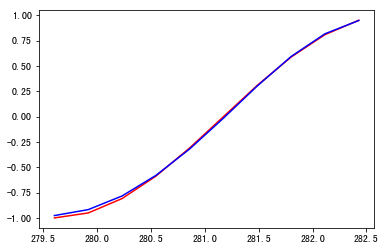

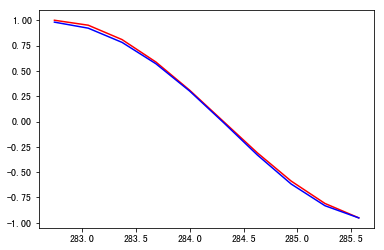

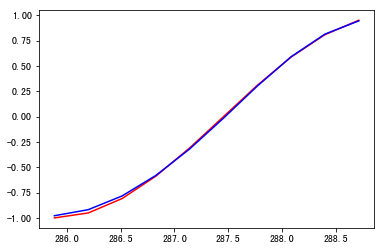

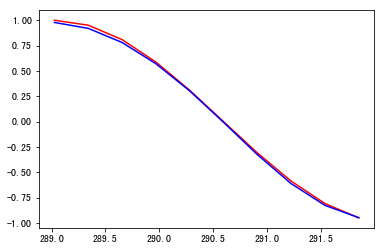

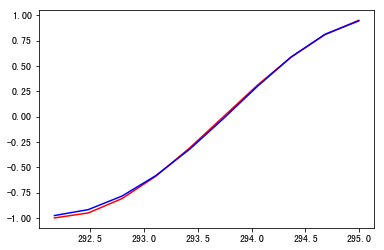

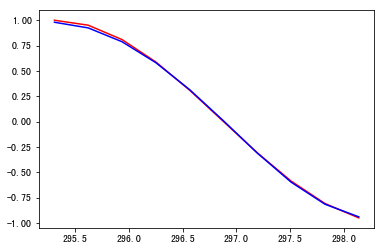

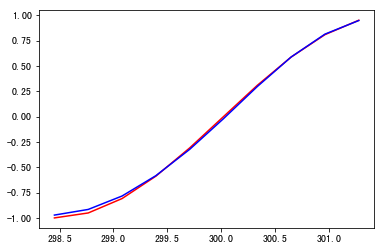

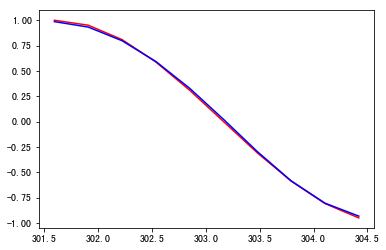

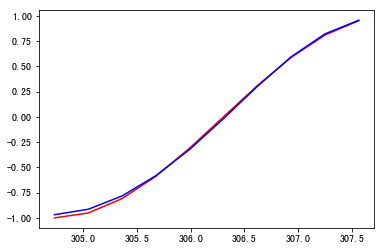

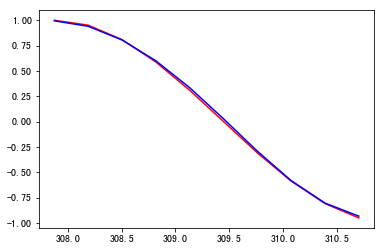

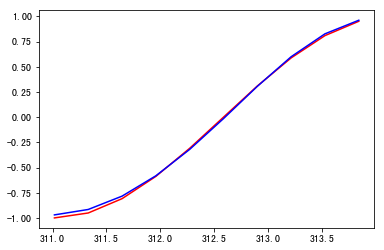

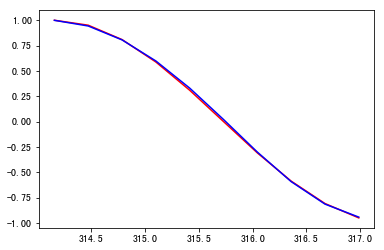

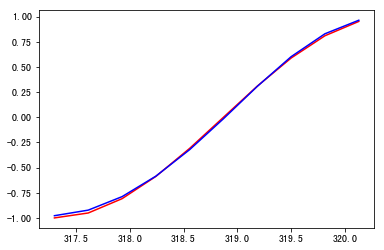

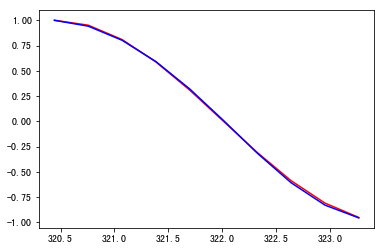

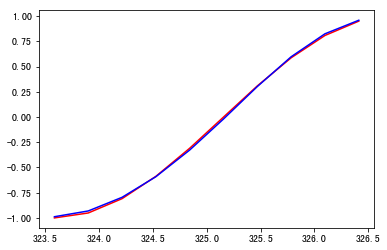

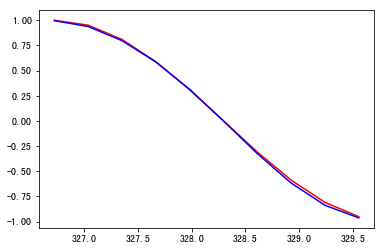

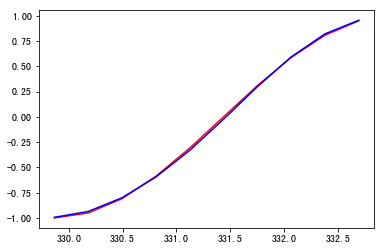

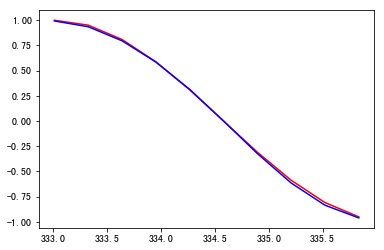

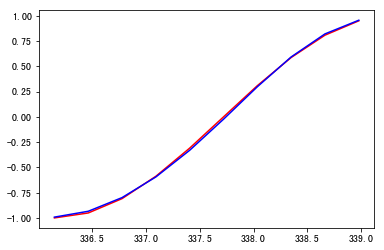

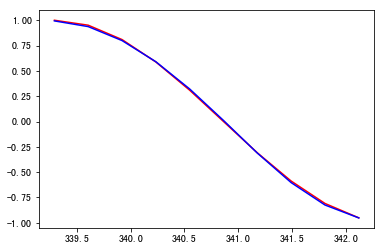

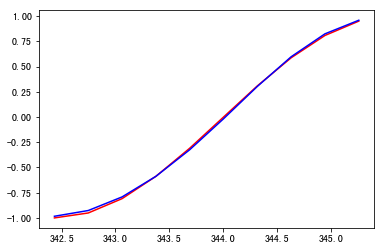

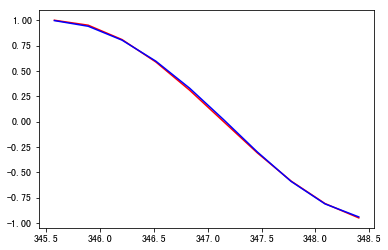

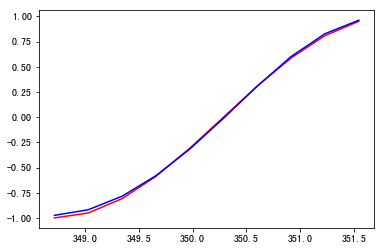

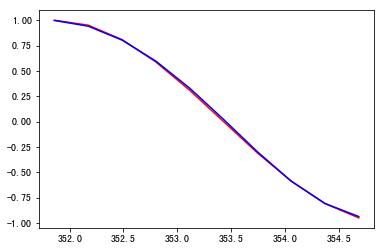

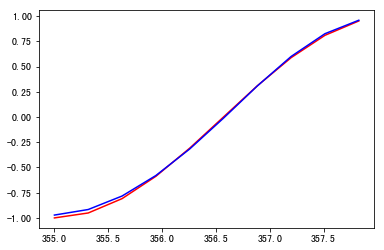

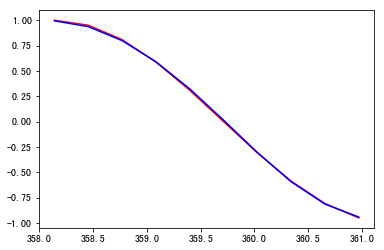

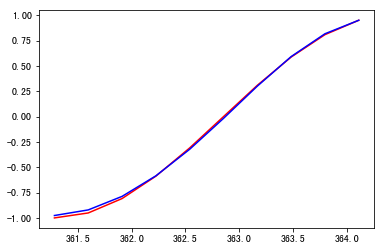

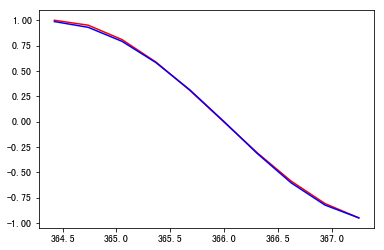

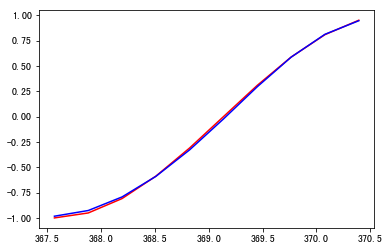

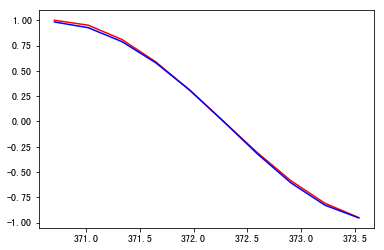

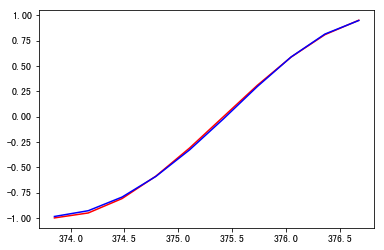

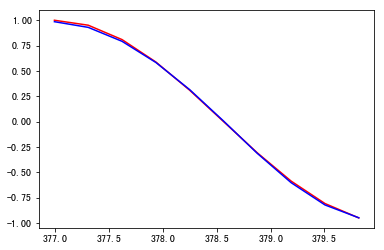

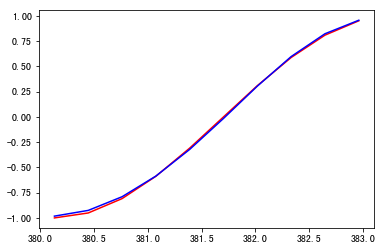

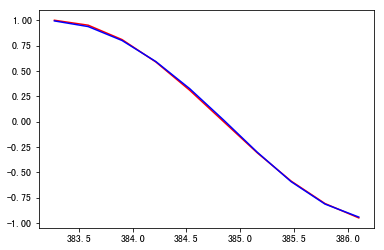

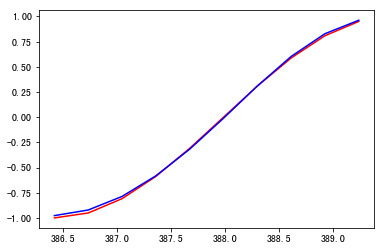

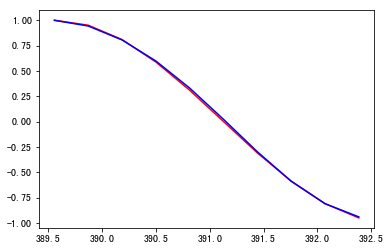

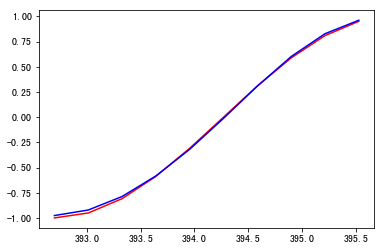

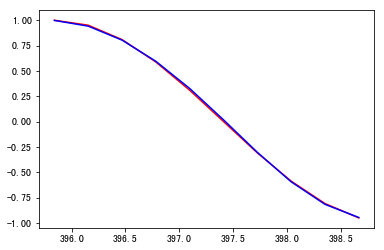

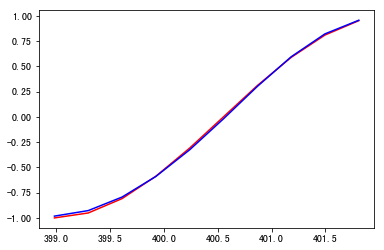

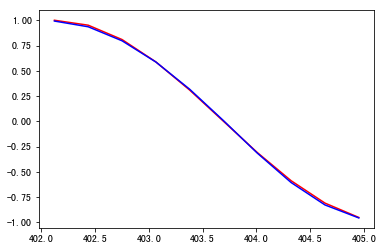

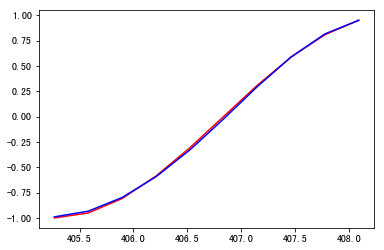

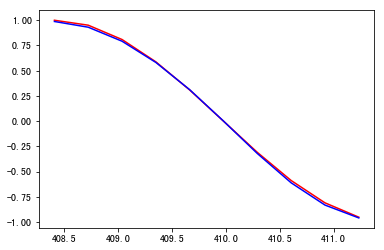

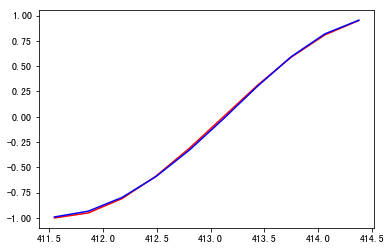

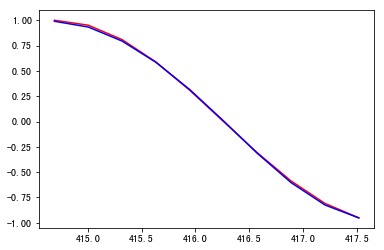

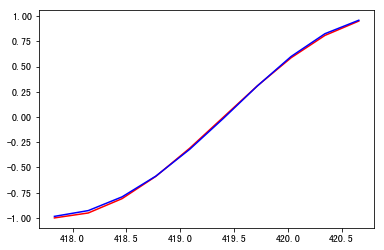

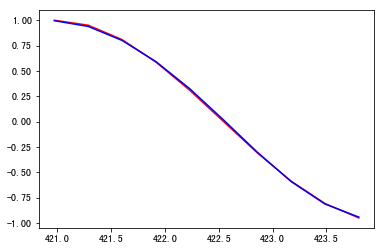

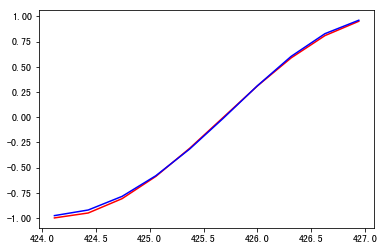

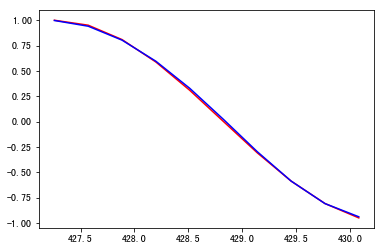

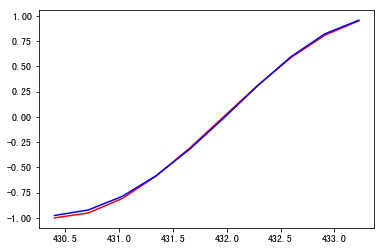

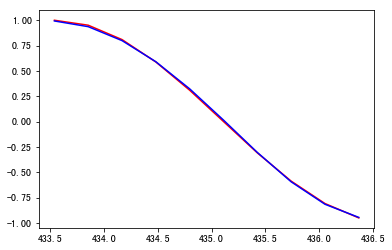

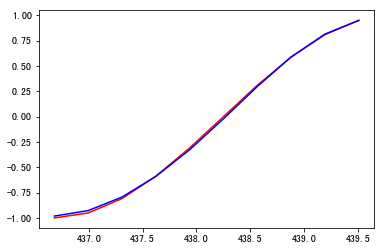

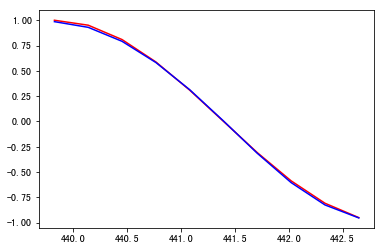

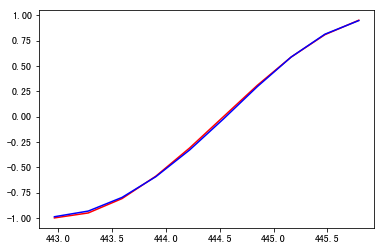

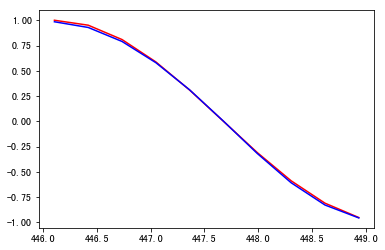

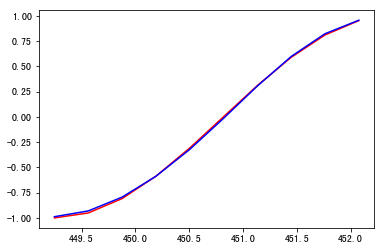

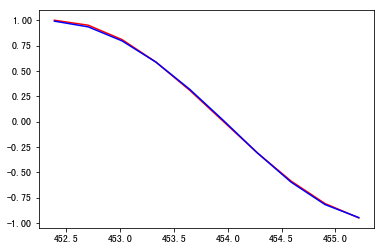

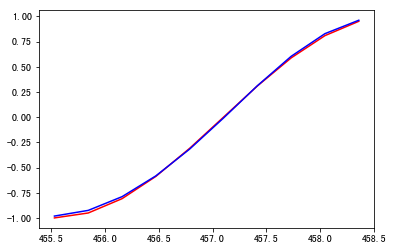

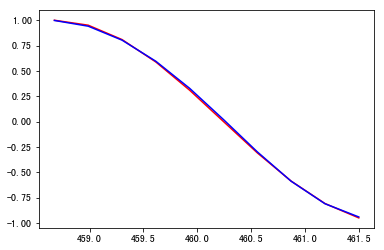

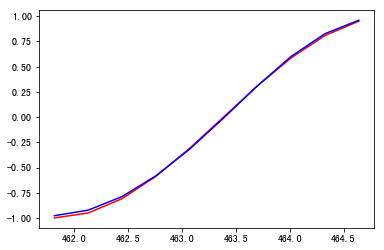

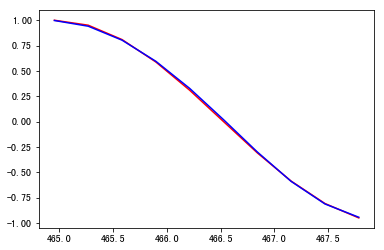

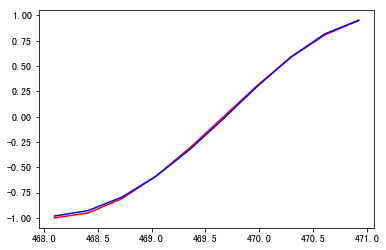

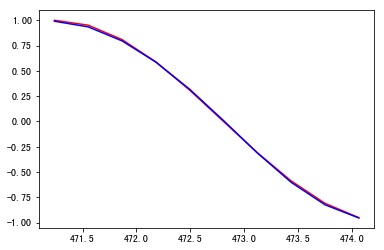

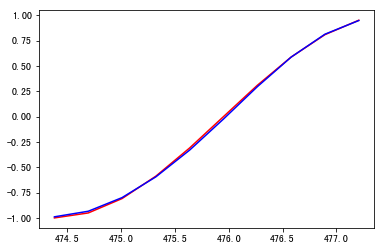

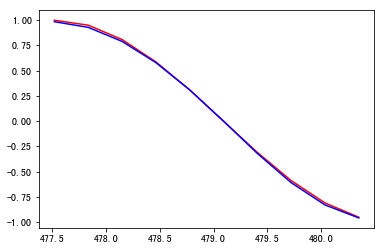

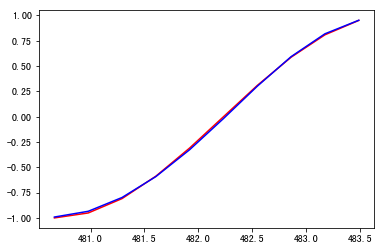

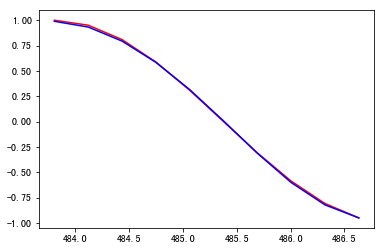

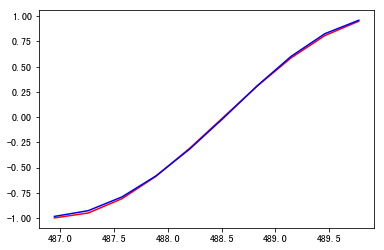

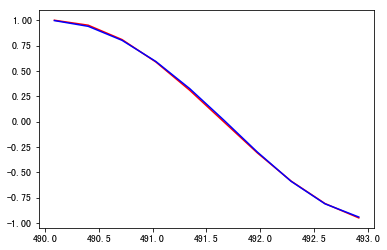

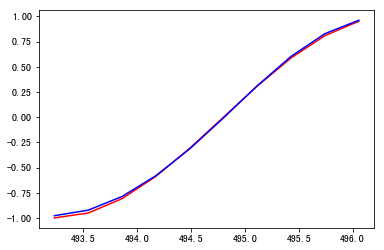

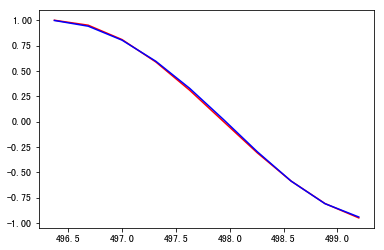

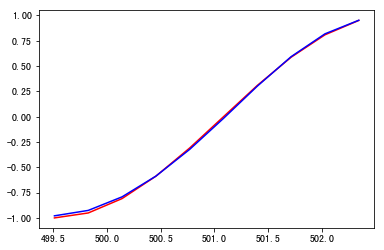

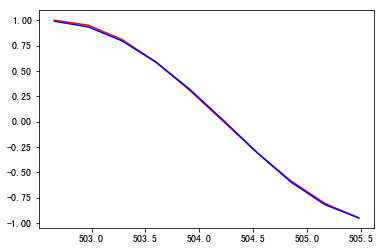

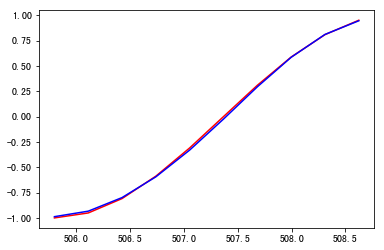

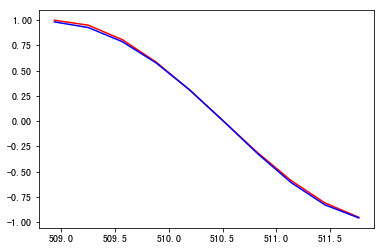

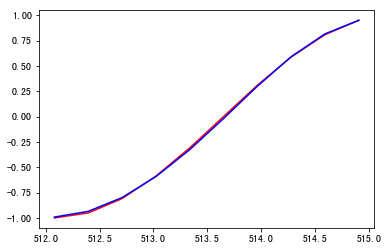

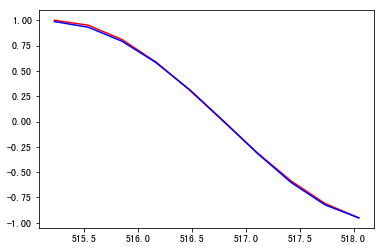

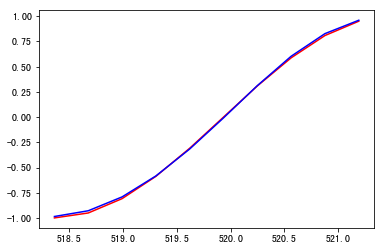

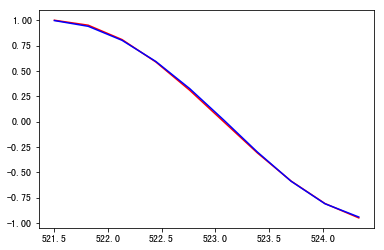

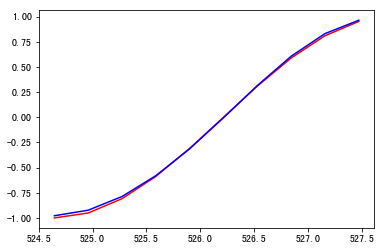

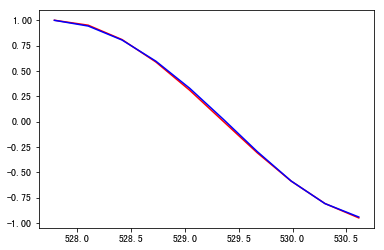

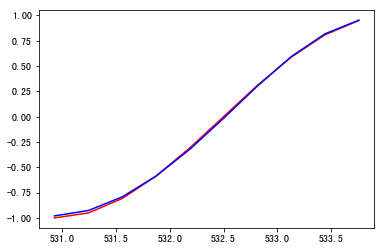

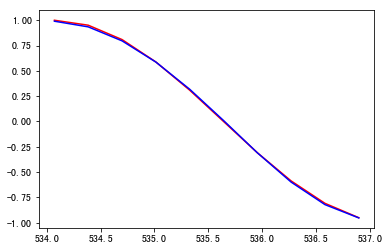

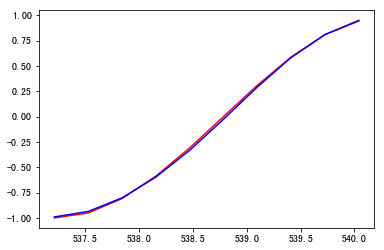

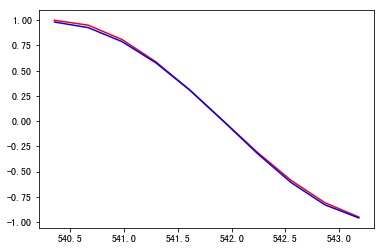

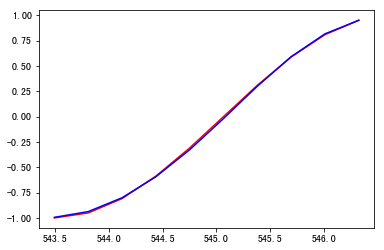

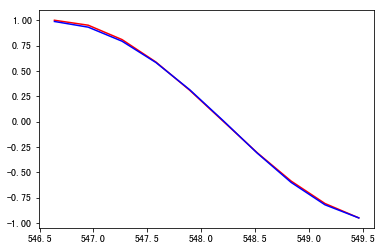

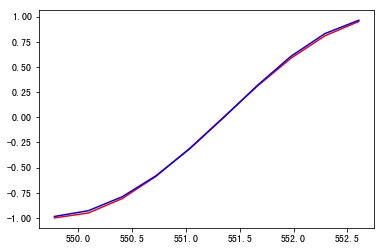

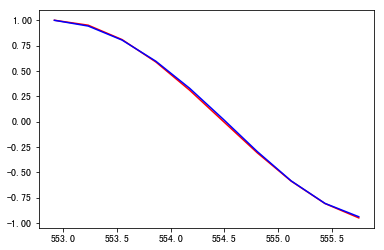

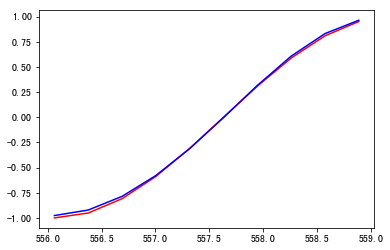

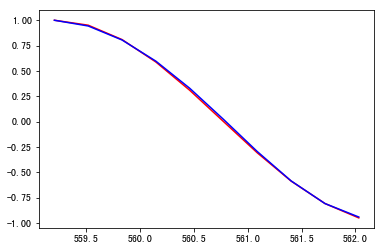

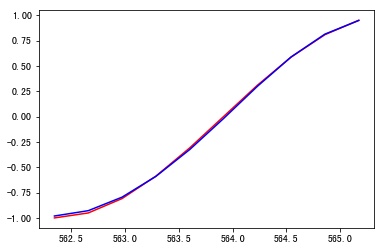

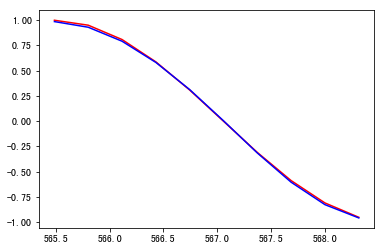

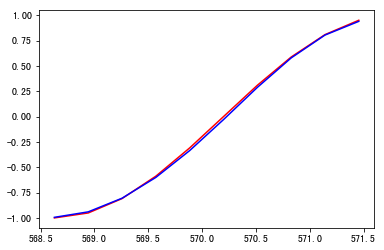

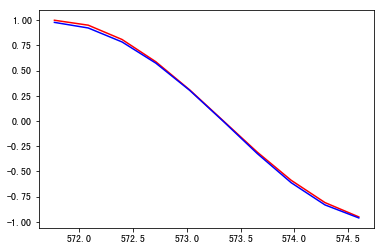

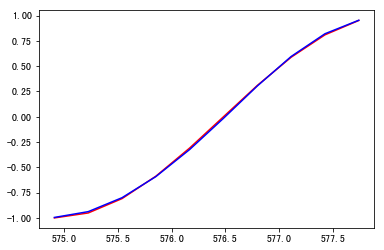

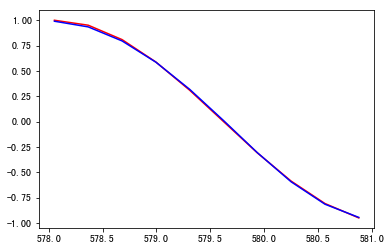

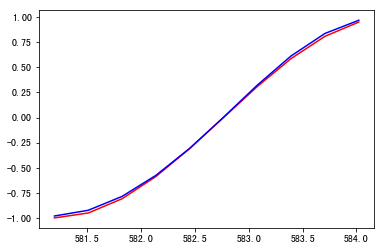

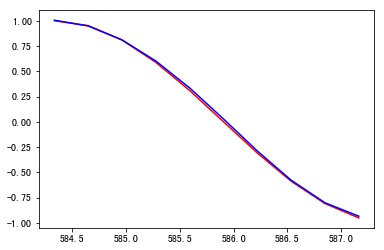

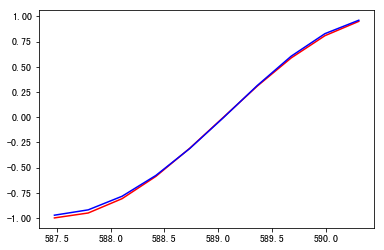

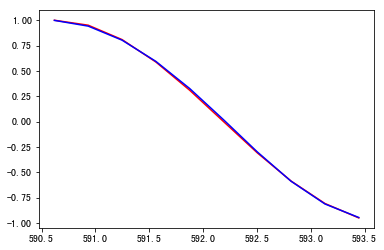

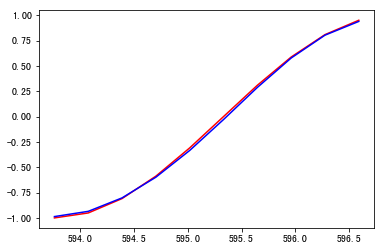

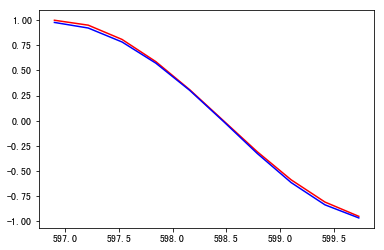

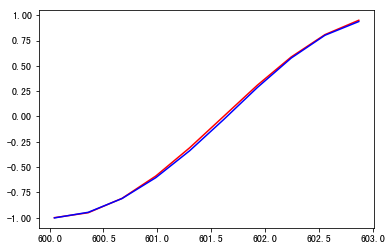

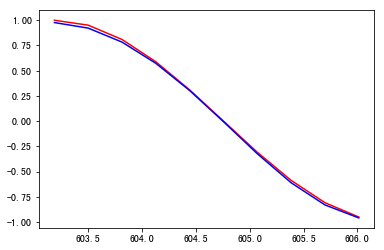

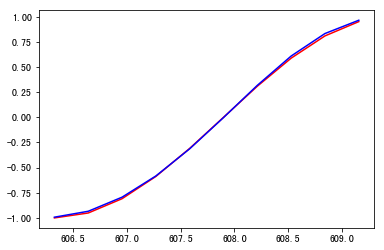

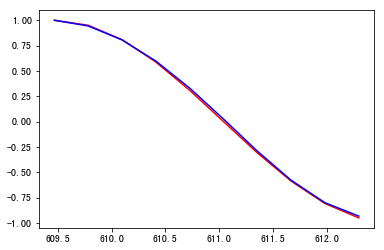

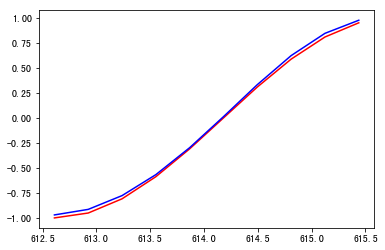

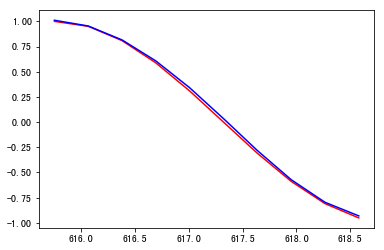

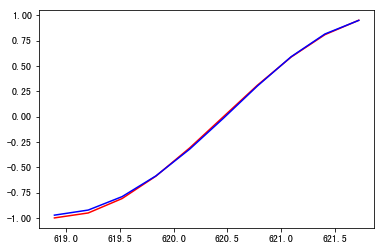

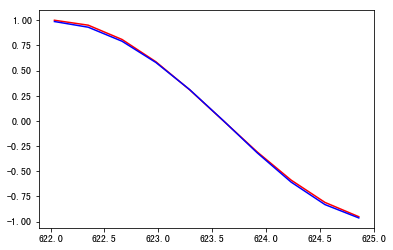

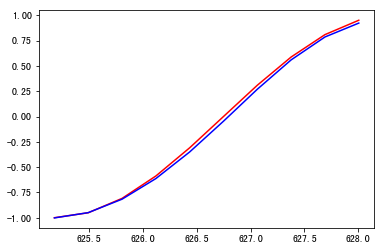

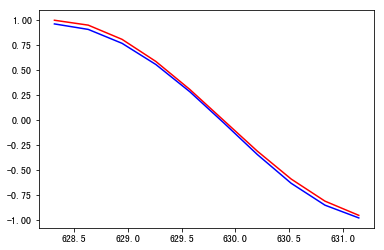

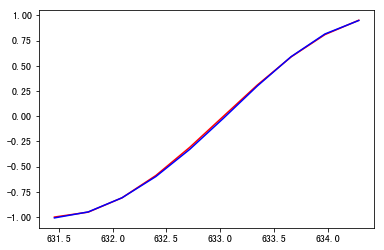

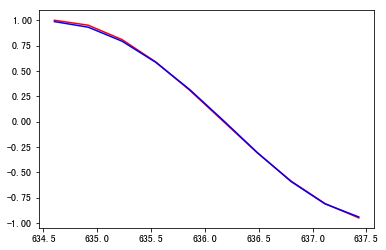

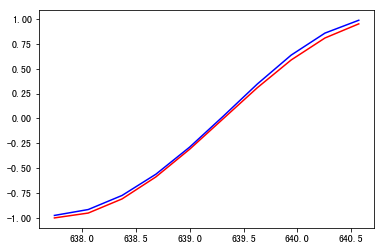

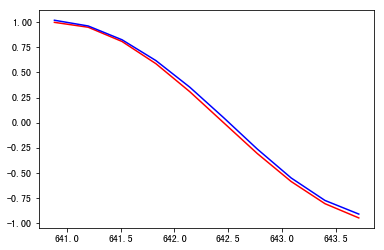

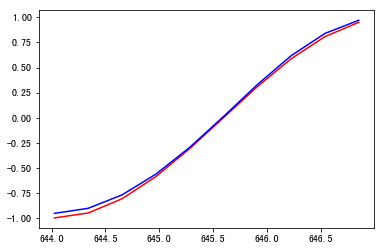

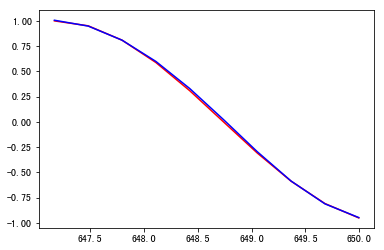

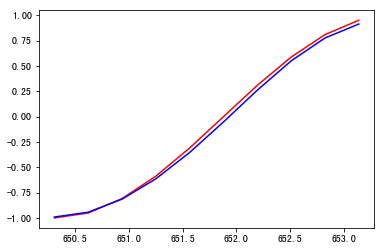

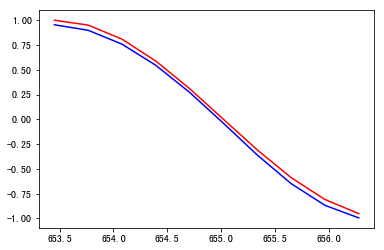

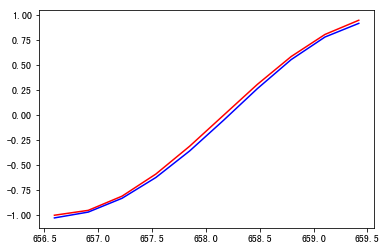

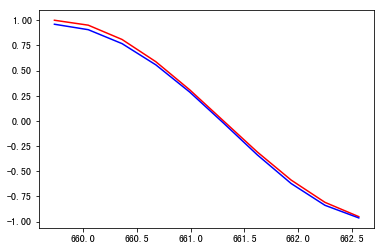

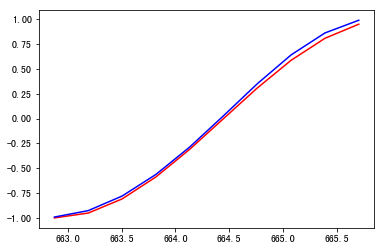

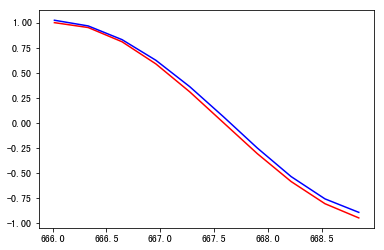

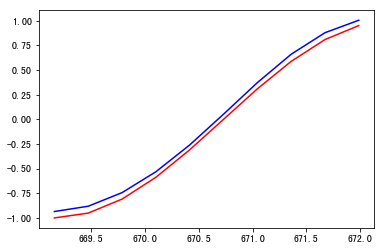

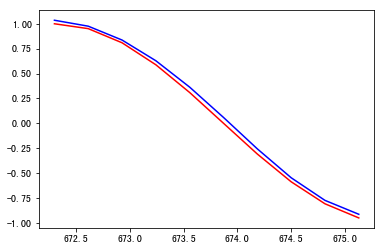

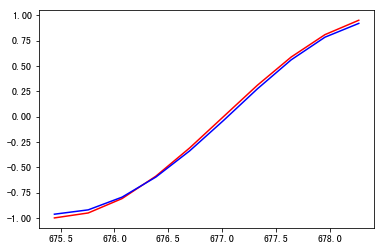

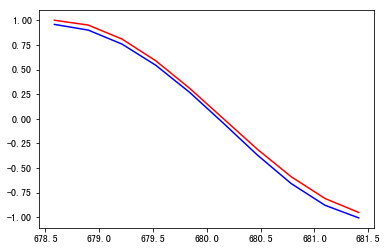

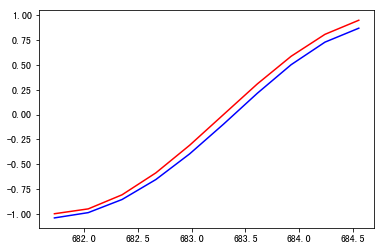

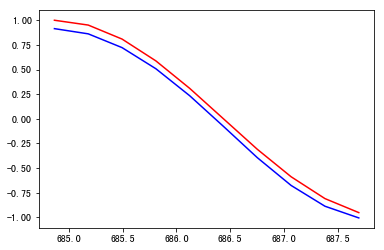

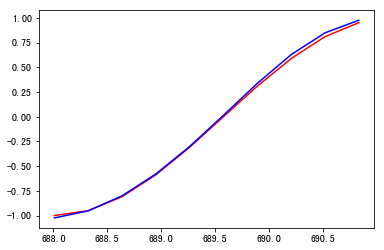

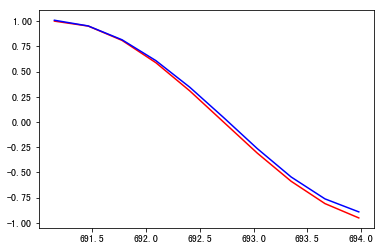

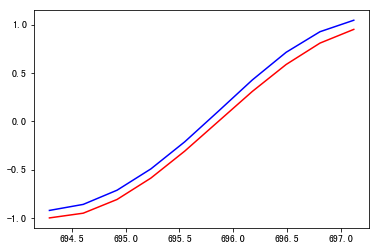

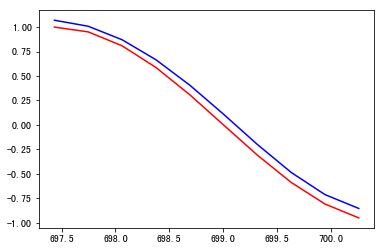

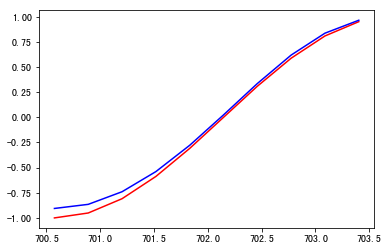

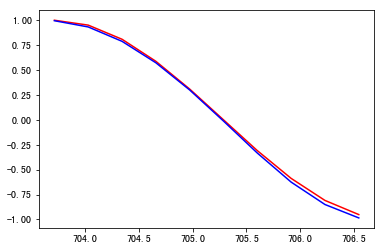

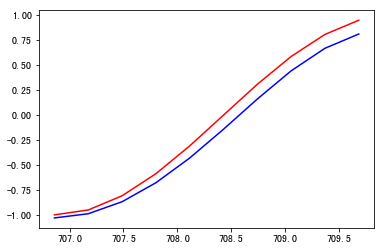

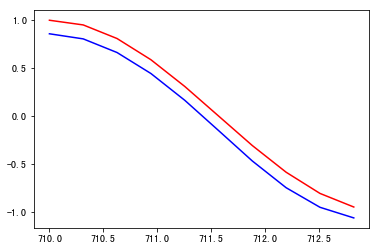

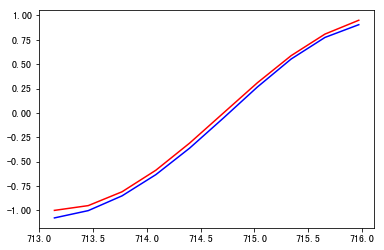

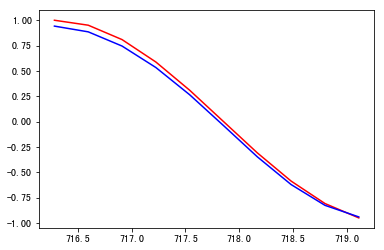

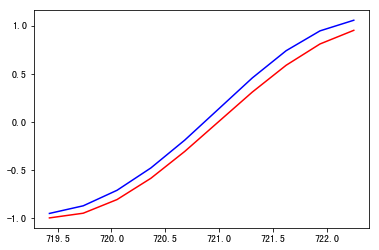

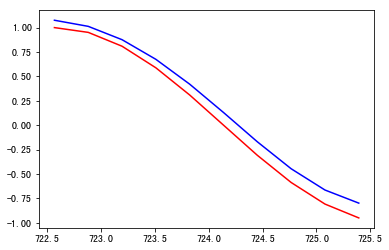

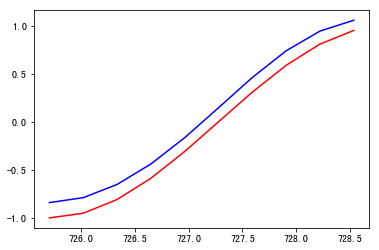

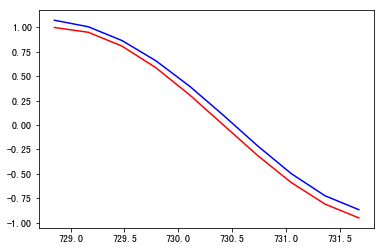

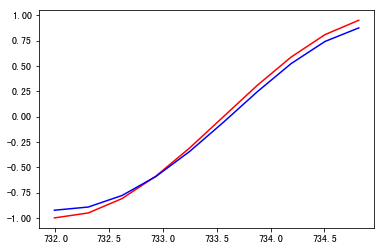

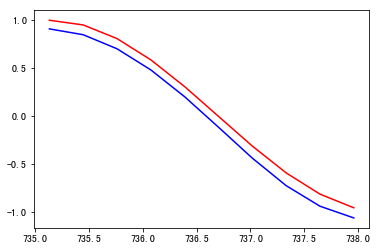

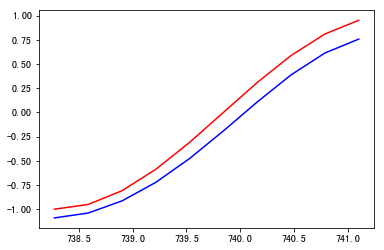

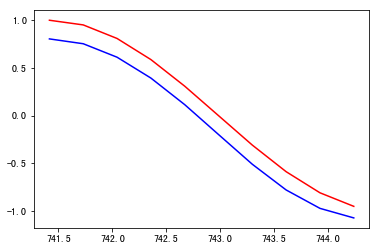

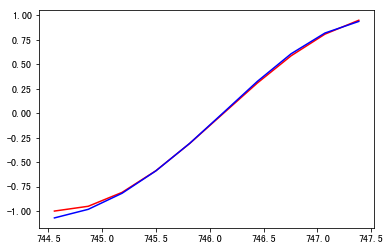

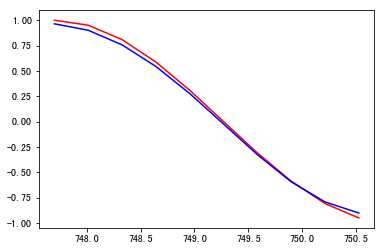

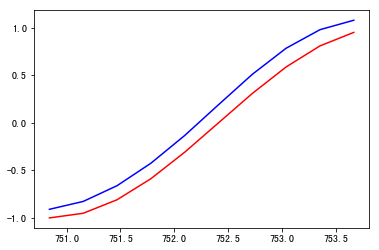

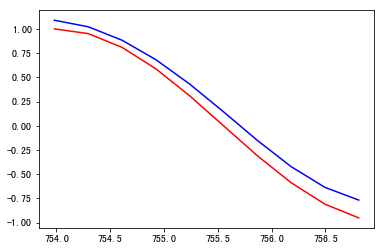

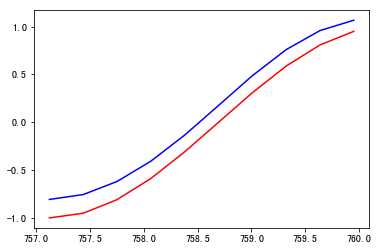

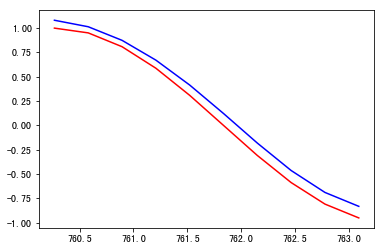

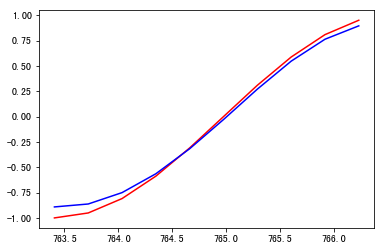

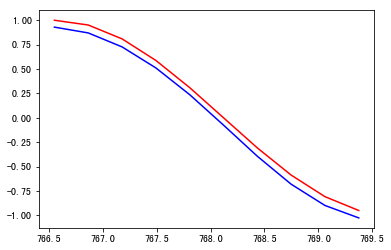

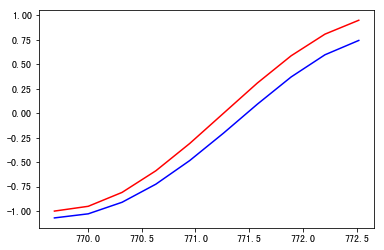

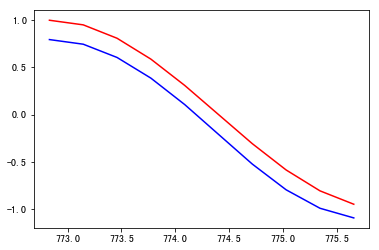

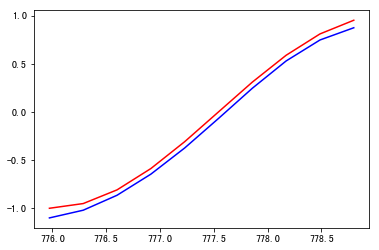

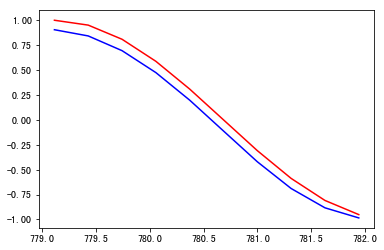

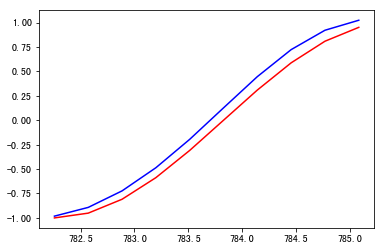

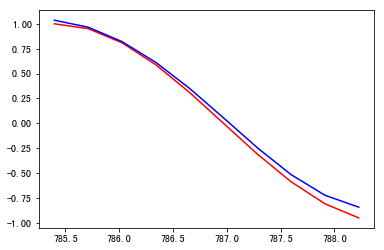

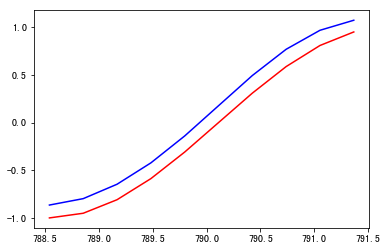

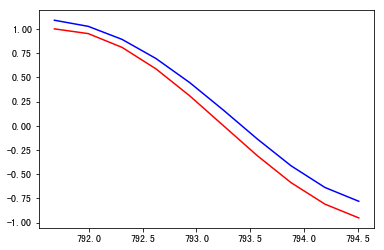

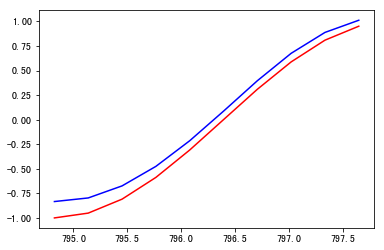

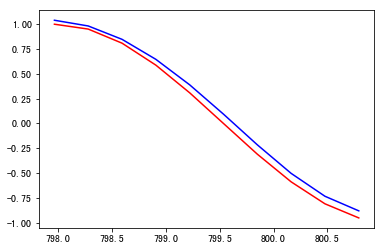

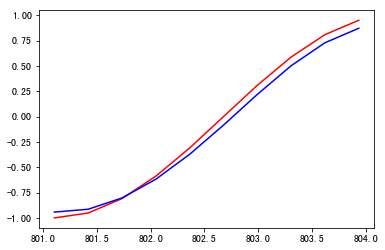

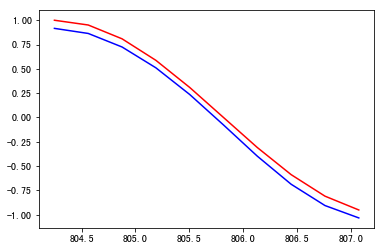

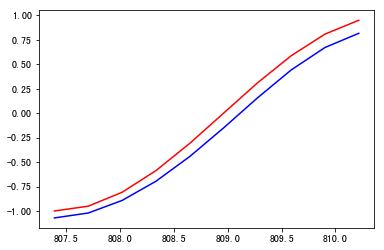

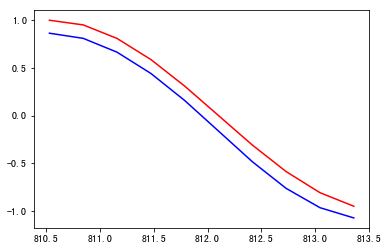

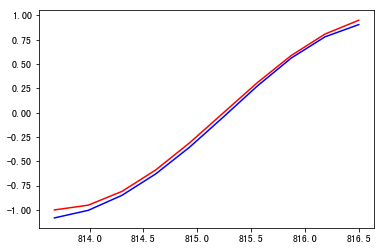

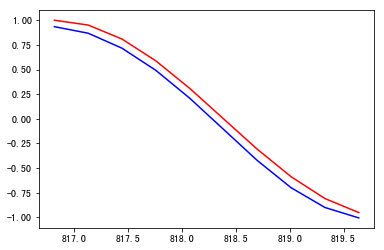

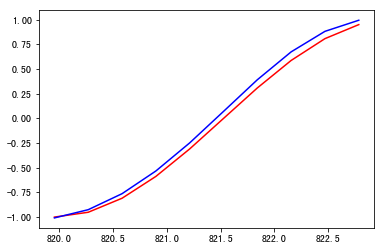

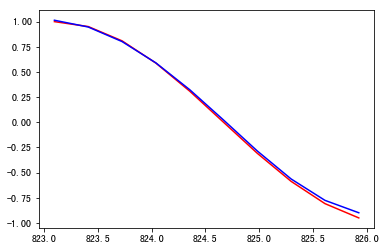

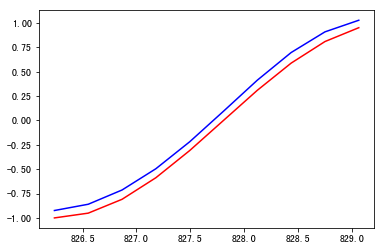

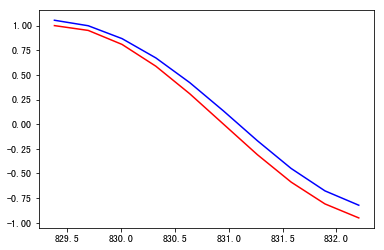

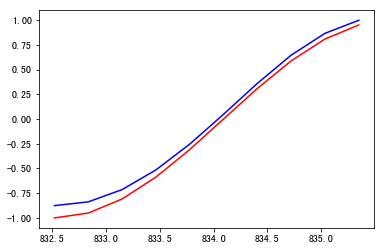

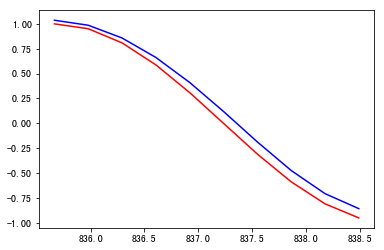

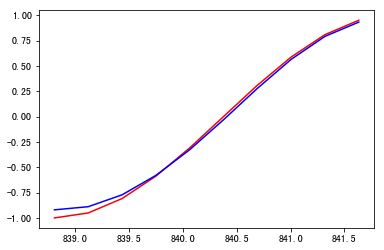

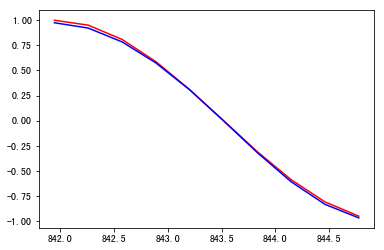

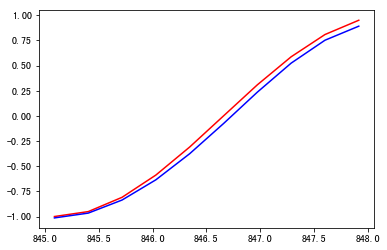

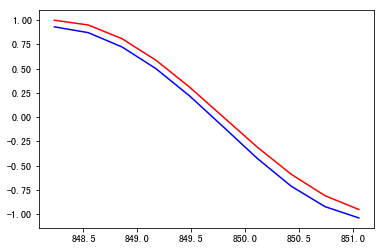

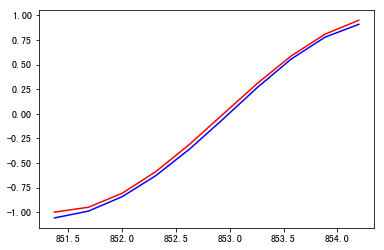

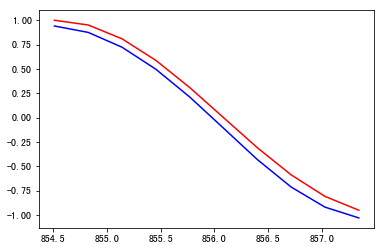

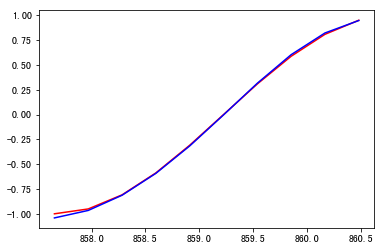

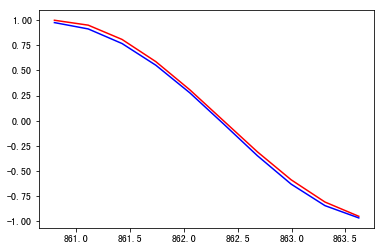

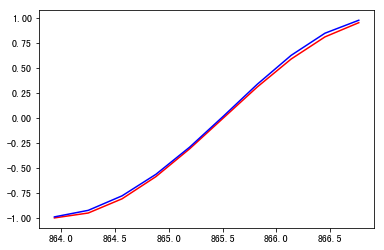

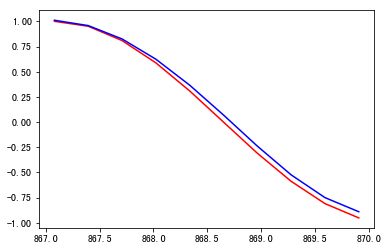

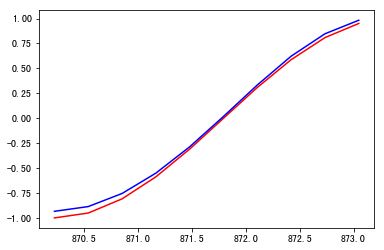

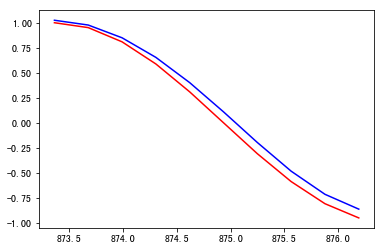

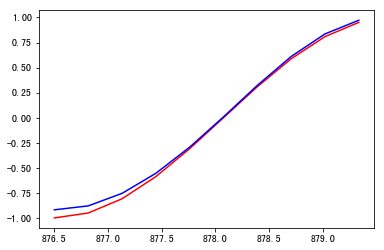

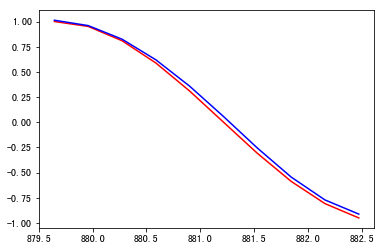

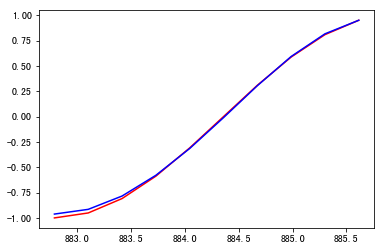

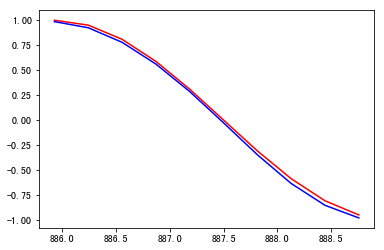

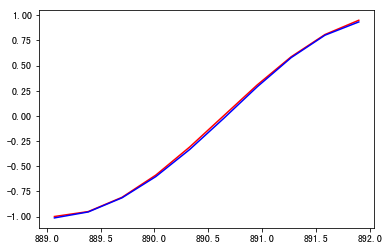

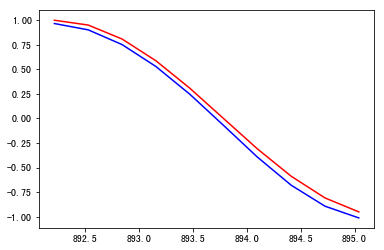

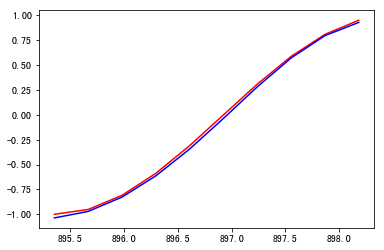

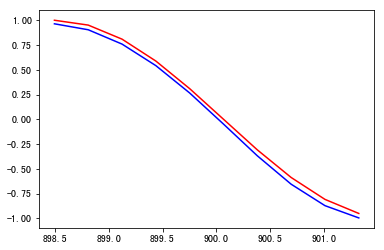

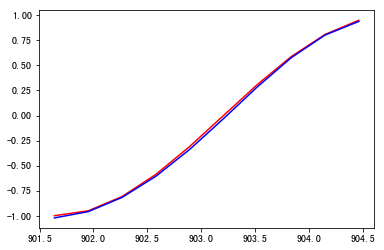

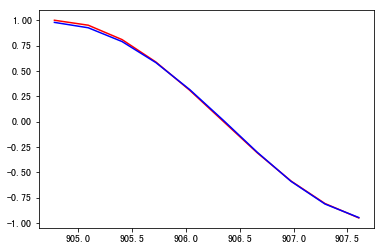

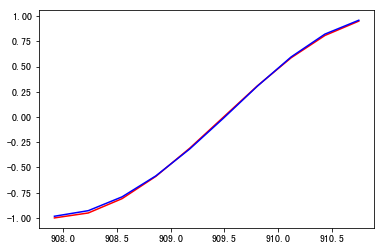

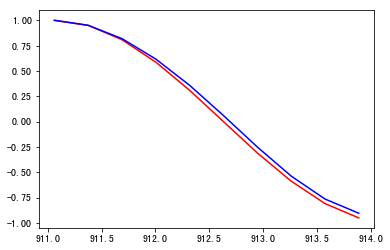

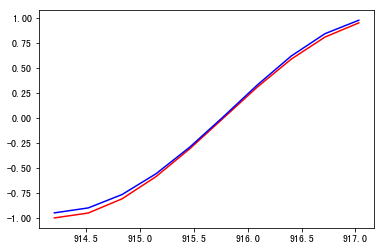

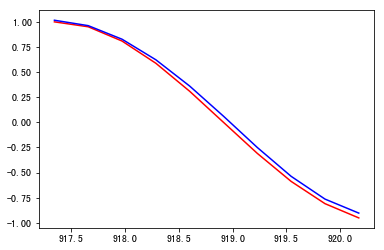

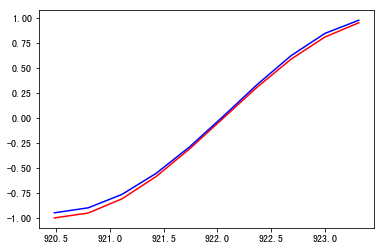

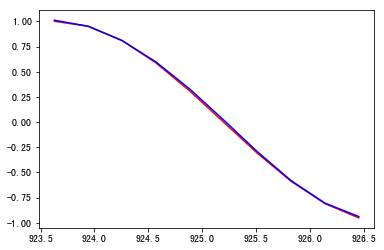

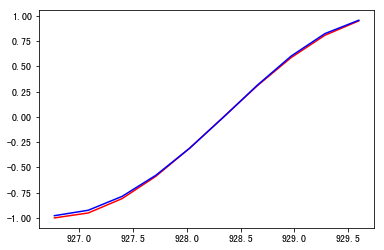

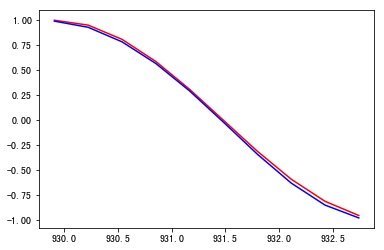

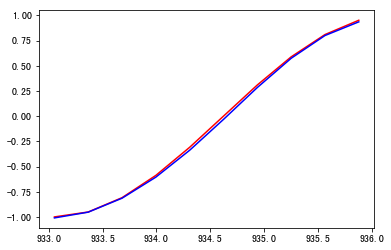

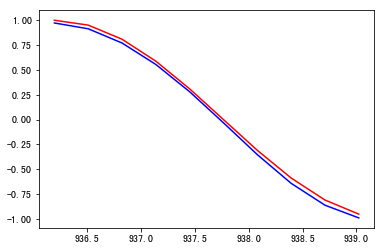

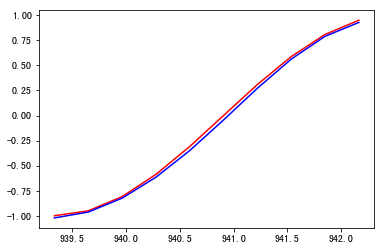

In [12]:
# 开始训练
net.train()
plt.figure(1, figsize=(12, 5))
plt.ion()
for step in range(EPOCH):
    start, end = step * np.pi, (step+1)*np.pi # 一个时间周期
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32, endpoint=False)
    np_x = np.sin(steps)
    np_y = np.cos(steps)
    x = torch.from_numpy(np_x[np.newaxis, :, np.newaxis])
    y = torch.from_numpy(np_y[np.newaxis, :, np.newaxis])
    prediction, h_state = net(x, h_state)   
    h_state = h_state.data      # 重置隐藏层的状态, 切断和前一次迭代的链接
    loss = criteria(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # plot
    plt.plot(steps, np_y.flatten(), 'r')
    plt.plot(steps, prediction.data.numpy().flatten(), 'b')
    plt.draw();plt.pause(0.5)

plt.ioff()
plt.show()